# Análise - Empresa de Mídia

Esse notebook foi criado para analisar os dados de uma empresa de mídia hipotética.

Os objetivos são:
- Investigar o que pode estar causando a queda na audiência da empresa e demonstrar como seria a série de pageviews caso esse problema fosse resolvido.
- Fazer uma previsão do número de pageviews dos dias 5, 6 e 7 de maio.

Sumário

1. Descrição do problema
2. Análise exploratória dos dados
3. Pré-processamento
4. Análise da queda de pageviews
5. Simulação do problema resolvido
6. Previsão de pageviews
7. Conclusão

# 1. Descrição do problema

Para entender o comportamento da audiência, a empresa acompanha algumas métricas como: pageviews, usuários e sessões.

Um usuário pode acessar uma página e consumir os conteúdos do site, cada página que o usuário abre corresponde a um pageview e cada vez que ele navega em um conjunto de páginas corresponde a uma sessão.

De acordo com o gráfico, há uma tendência de queda na principal métrica de audiência, o número de pageviews.

<img src="https://raw.githubusercontent.com/BrennoLins/GithubRepo/main/grafico_desafio.png" width="450">

Para descobrir a causa desse problema, vamos investigar se existe uma relação da queda de pageviews com alguma variável específica, ou se a queda é proporcional em todos os recortes possíveis.

Após determinada a principal causa do problema, será realizada uma simulação da série de pageviews caso esse problema fosse resolvido.

Por fim, faremos uma previsão do número de pageviews total dos dias 5, 6 e 7 de maio com base nos dados passados.

# 2. Análise exploratória dos dados

Realizaremos a análise exploratória dos dados para compreender a natureza dos dados, observar a relação entre as métricas e identificar problemas como dados faltantes ou inconsistentes.

O dataset possui 834,810 linhas e as seguintes colunas:

- date: data de observação da audiência. O dataset vai de 01/jan/2021 a 03/mai/2021.

- hits_hour: horário de observação da audiência. hits_hour = 10 significa que está agregando de 10h00 até 10h59.

- geoNetwork_region: Unidade da Federação.

- device_deviceCategory: dispositivo utilizado.

- editoria: agrupamento de matérias por assunto. Este dataset possui um total de 39 editorias.

- trafficSource_medium: A mídia da origem de tráfego.

- trafficSource_source: A origem do tráfego.

- variable: tipo de métrica (pageviews, usuários ou sessões).

- value: valor da métrica.

In [1]:
# importações
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.interpolate import make_interp_spline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools

# leitura do arquivo com os dados
df = pd.read_csv('/kaggle/input/dados-desafio/dados_desafio.csv')

In [2]:
# visualização das primeiras linhas do dataset
df.head()

,date,hits_hour,geoNetwork_region,device_deviceCategory,editoria,trafficSource_medium,trafficSource_source,variable,value
0,20210101,0,Federal District,mobile,editoria_01,(none),(direct),usuarios,14
1,20210101,0,Federal District,mobile,editoria_01,(none),(direct),sessoes,15
2,20210101,0,Federal District,mobile,editoria_01,(none),(direct),pageviews,18
3,20210101,0,Federal District,mobile,editoria_01,organic,google,usuarios,14
4,20210101,0,Federal District,mobile,editoria_01,organic,google,sessoes,15


As datas não estão no formato ideal.

In [3]:
# visualização dos data types e da contagem de não nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834810 entries, 0 to 834809
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   date                   834810 non-null  object
 1   hits_hour              834810 non-null  int64 
 2   geoNetwork_region      834810 non-null  object
 3   device_deviceCategory  834810 non-null  object
 4   editoria               834810 non-null  object
 5   trafficSource_medium   834810 non-null  object
 6   trafficSource_source   834810 non-null  object
 7   variable               834810 non-null  object
 8   value                  834810 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 57.3+ MB


Não existem valores nulos.

In [4]:
# descrição das tendências das variáveis numéricas
df.describe().style.format('{:,.2f}')

,hits_hour,value
count,"834,810.00","834,810.00"
mean,14.21,48.67
std,5.85,99.94
min,0.00,1.00
25%,10.00,16.00
50%,15.00,24.00
75%,19.00,46.00
max,23.00,"8,048.00"


A variável value possui valor máximo muito acima da média, mas esse valor não é um outlier. Quando há algum furo de reportagem ou matéria polêmica, a audiência é muito maior que o normal.

In [5]:
# visualização da contagem dos valores das variáveis
for i in df.columns:
    print('---------------------------------------\n')
    print(df[[i]].value_counts())
    print()

---------------------------------------

date       
20210117       12546
20210402       10335
20210314       10212
20210120        9954
20210123        9909
               ...  
16-jan-2021        3
31-mar-2021        3
01-fev-2021        3
01-abr-2021        3
25-abr-2021        2
Length: 516, dtype: int64

---------------------------------------

hits_hour
20           53138
21           52258
19           51336
18           49101
16           47788
22           47593
17           47395
13           47034
14           46666
15           46634
12           43877
11           41715
10           38873
9            37214
8            35526
23           35070
7            31328
0            22699
6            22031
1            11442
5            10546
2             6267
4             5037
3             4242
dtype: int64

---------------------------------------

geoNetwork_region           
State of Sao Paulo              226612
State of Rio de Janeiro          92478
State of Minas Gerai

As datas estão em diversos formatos diferentes.

Algumas editorias estão com pequenos erros no nome.

Podemos perceber que existe relação entre trafficSource_medium (mídia da origem de tráfego) e trafficSource_source (origem do tráfego).

Também é possível perceber que existe relação entre os tipos de métrica (pageviews, usuários e sessões).

# 3. Pré-processamento

Nessa etapa será feita a limpeza dos dados, a seleção de características, a transformação de variáveis e outros tratamentos, caso necessários.

In [6]:
# formatação das datas

# substituição do mês pela forma numérica
df['date'] = df['date'].str.replace('jan', '01')
df['date'] = df['date'].str.replace('fev', '02')
df['date'] = df['date'].str.replace('mar', '03')
df['date'] = df['date'].str.replace('abr', '04')
df['date'] = df['date'].str.replace('mai', '05')

# substituição de - por /
df['date'] = df['date'].str.replace('-', '/')

# substituição de 21 por 2021 nas datas que começam com o ano
df['date'] = df['date'].str.replace(r'^21(/\d\d/\d\d)$', r'2021\1', regex=True)

# substituição de 21 por 2021 nas datas que terminam com o ano
df['date'] = df['date'].str.replace(r'^(\d\d/\d\d/)21$', r'\g<1>2021', regex=True)

# inversão das datas de dd/mm/yyyy para yyyy/mm/dd
df['date'] = df['date'].str.replace(r'^(\d\d)/(\d\d)/2021', r'2021/\2/\1', regex=True)

# remoção da /
df['date'] = df['date'].str.replace('/', '')

# visualização das datas
df['date'].value_counts()

20210117    12864
20210314    11112
20210402    11010
20210305    10404
20210123    10176
            ...  
20210209     3609
20210206     3582
20210424     3548
20210425     3392
20210205     3180
Name: date, Length: 123, dtype: int64

In [7]:
# conversão do tipo da data para datetime64
df['date'] = pd.to_datetime(df.date)

In [8]:
# correção das editorias
df['editoria'] = df['editoria'].str.replace('editeria_01', 'editoria_01')
df['editoria'] = df['editoria'].str.replace('editoria_07 ', 'editoria_07')
df['editoria'] = df['editoria'].str.replace('Editoria_05', 'editoria_05')
df['editoria'] = df['editoria'].str.replace('editoria 11', 'editoria_11')

In [9]:
# a variável hits_hour não é relevante porque vamos analisar o total de pageviews do dia

# remoção da coluna hits_hour
df_sem_hit = df.drop('hits_hour', 1)

In [10]:
# queremos analisar pageviews, usuários e sessões separadamente

# filtro de pageviews na coluna variable
df_pag = df_sem_hit[(df_sem_hit['variable'] == 'pageviews')]
# exclusão da coluna variable
df_pag = df_pag.drop('variable', 1)
# alteração do nome da coluna value
df_pag = df_pag.rename(columns = {'value': 'value_pag'})

# filtro de usuários na coluna variable
df_usu = df_sem_hit[(df_sem_hit['variable'] == 'usuarios')]
# exclusão da coluna variable
df_usu = df_usu.drop('variable', 1)
# alteração do nome da coluna value
df_usu = df_usu.rename(columns = {'value': 'value_usu'})

# filtro de sessões na coluna variable
df_ses = df_sem_hit[(df_sem_hit['variable'] == 'sessoes')]
# exclusão da coluna variable
df_ses = df_ses.drop('variable', 1)
# alteração do nome da coluna value
df_ses = df_ses.rename(columns = {'value': 'value_ses'})

In [11]:
# agrupamento das linhas, somando value

df_pag = df_pag.groupby([
    'date',
    'geoNetwork_region',
    'device_deviceCategory',
    'editoria',
    'trafficSource_medium',
    'trafficSource_source'
    ]).agg({'value_pag': 'sum'}).reset_index()

df_usu = df_usu.groupby([
    'date',
    'geoNetwork_region',
    'device_deviceCategory',
    'editoria',
    'trafficSource_medium',
    'trafficSource_source'
    ]).agg({'value_usu': 'sum'}).reset_index()

df_ses = df_ses.groupby([
    'date',
    'geoNetwork_region',
    'device_deviceCategory',
    'editoria',
    'trafficSource_medium',
    'trafficSource_source'
    ]).agg({'value_ses': 'sum'}).reset_index()

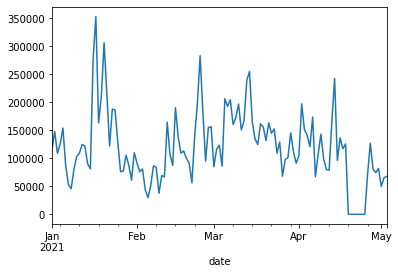

In [12]:
# visualização do número de pageviews por dia
df_pag_d = df_pag.set_index('date')
df_pag_d = df_pag_d['value_pag'].resample('D').sum()
df_pag_d.plot();

Existe um intervalo em abril onde o número de pageviews foi zero. Será necessário realizar tratamento de missings.

In [13]:
# faremos o tratamento de missings de pageviews usando como base o valor de sessões ou de usuários

# união de df_pag, df_usu e df_ses

df_metricas_separadas = pd.merge(
    df_usu,
    df_ses,
    how = 'outer',
    on = ['date', 'geoNetwork_region', 'device_deviceCategory', 'editoria', 'trafficSource_medium', 'trafficSource_source'])

df_metricas_separadas = pd.merge(
    df_metricas_separadas,
    df_pag,how = 'outer',
    on = ['date', 'geoNetwork_region', 'device_deviceCategory', 'editoria', 'trafficSource_medium', 'trafficSource_source'])

# visualização das primeiras linhas
df_metricas_separadas.head()

,date,geoNetwork_region,device_deviceCategory,editoria,trafficSource_medium,trafficSource_source,value_usu,value_ses,value_pag
0,2021-01-01,Federal District,desktop,editoria_11,organic,google,1,1,14.0
1,2021-01-01,Federal District,desktop,editoria_12,organic,google,1,1,14.0
2,2021-01-01,Federal District,mobile,editoria_01,(none),(direct),820,833,996.0
3,2021-01-01,Federal District,mobile,editoria_01,organic,google,725,729,870.0
4,2021-01-01,Federal District,mobile,editoria_01,referral,googleapis.com,380,380,465.0


In [14]:
# correlação entre pageviews, sessões e usuários
df_metricas_separadas.corr().style.format('{:,.3f}')

,value_usu,value_ses,value_pag
value_usu,1.000,0.890,0.999
value_ses,0.890,1.000,0.887
value_pag,0.999,0.887,1.000


A correlação de pageviews com usuários é maior do que a de pageviews com sessões.

Usaremos o valor de usuários como base para preencher os missings de pageviews.

In [15]:
# cálculo da relação entre a média de pageviews e de usuários
coef = df_metricas_separadas['value_pag'].mean() / df_metricas_separadas['value_usu'].mean()
coef

1.2541930385740836

In [16]:
# substituição dos missings por value_usu multiplicado pelo coeficiente calculado
df_metricas_separadas['value_pag'].fillna(df_metricas_separadas['value_usu'] * coef, inplace = True)

# transformação de value_pag em integer
df_metricas_separadas['value_pag'] = df_metricas_separadas['value_pag'].astype(int)

In [17]:
# remoção das colunas value_ses e value_usu
df_tratado = df_metricas_separadas.drop(['value_ses', 'value_usu'], 1)

# visualização das primeiras linhas do dataset tratado
df_tratado.head()

,date,geoNetwork_region,device_deviceCategory,editoria,trafficSource_medium,trafficSource_source,value_pag
0,2021-01-01,Federal District,desktop,editoria_11,organic,google,14
1,2021-01-01,Federal District,desktop,editoria_12,organic,google,14
2,2021-01-01,Federal District,mobile,editoria_01,(none),(direct),996
3,2021-01-01,Federal District,mobile,editoria_01,organic,google,870
4,2021-01-01,Federal District,mobile,editoria_01,referral,googleapis.com,465


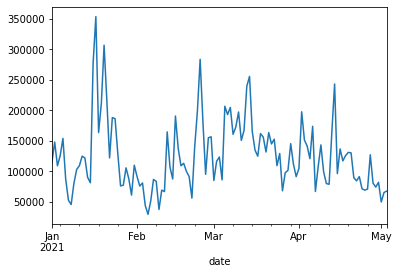

In [18]:
# visualização do número de pageviews por dia após o tratamento de missings
df_tratado_d = df_tratado.set_index('date')
df_tratado_d = df_tratado_d['value_pag'].resample('D').sum()
df_tratado_d.plot();

In [19]:
# criação de uma coluna de mês
df_tratado['mes'] = df_tratado['date'].dt.month

# número de pageviews por mês após o tratamento de missings
df_tratado.groupby(['mes']).agg({'value_pag': 'sum'})

,value_pag
mes,
1,4219600
2,3085372
3,4546943
4,3450714
5,182918


# 4. Análise da queda de pageviews

Para descobrir a causa da queda de pageviews, vamos analisar a quantidade de pageviews por mês de cada variável, separadamente, dividindo o total de pageviews do mês pelo número de dias daquele mês, para obter o número médio de pageviews por dia.

In [20]:
# criação de uma lista com a quantidade de dias de cada mês
n_dias = [31, 28, 31, 30, 3]

In [21]:
# visualização do número médio de pageviews por dia de cada mês para a variável geoNetwork_region

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'geoNetwork_region',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

pd.set_option('display.max_columns', None)
df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 56172)

geoNetwork_region,Federal District,State of Acre,State of Alagoas,State of Amapa,State of Amazonas,State of Bahia,State of Ceara,State of Espirito Santo,State of Goias,State of Maranhao,State of Mato Grosso,State of Mato Grosso do Sul,State of Minas Gerais,State of Para,State of Paraiba,State of Parana,State of Pernambuco,State of Piaui,State of Rio Grande do Norte,State of Rio Grande do Sul,State of Rio de Janeiro,State of Rondonia,State of Roraima,State of Santa Catarina,State of Sao Paulo,State of Sergipe,State of Tocantins
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"3,019",0,293,48,"1,405","5,987","2,716","1,943","2,553",939,846,"1,263","15,362","1,591",637,"7,775","3,269",362,"1,057","7,411","17,346",140,6,"4,560","55,309",195,86
2,"2,554",0,235,22,673,"5,889","2,298","1,500","2,048",913,882,902,"11,943","1,261",518,"6,040","2,836",262,756,"5,689","12,468",88,0,"3,672","46,511",152,80
3,"3,476",1,422,15,705,"7,443","3,635","2,014","3,003","1,429","1,094","1,271","15,674","2,016",870,"8,873","4,155",527,"1,293","10,100","16,874",137,1,"5,061","56,172",258,156
4,"2,898",3,419,20,568,"5,493","2,943","1,712","2,289","1,126",850,"1,076","12,756","1,642",630,"6,410","3,485",500,996,"6,327","14,187",115,2,"3,714","44,522",216,127
5,"1,313",0,92,0,146,"3,468","1,607",720,"1,084",433,306,516,"7,557","1,332",180,"3,528","1,749",208,344,"3,113","7,260",10,0,"1,908","24,051",31,18


In [22]:
# visualização do número médio de pageviews por dia de cada mês para a variável device_deviceCategory

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'device_deviceCategory',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 141617)

device_deviceCategory,desktop,mobile,tablet
mes,,,
1,"2,185","133,826",105
2,"2,952","107,034",206
3,"4,773","141,617",286
4,"4,945","109,866",213
5,"2,682","57,997",294


In [23]:
# visualização do número médio de pageviews por dia de cada mês para a variável editoria

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'editoria',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 66550)

editoria,editoria_01,editoria_02,editoria_03,editoria_04,editoria_05,editoria_06,editoria_07,editoria_08,editoria_09,editoria_10,editoria_11,editoria_12,editoria_13,editoria_14,editoria_15,editoria_16,editoria_17,editoria_18,editoria_19,editoria_20,editoria_21,editoria_22,editoria_23,editoria_24,editoria_25,editoria_26,editoria_27,editoria_28,editoria_29,editoria_30,editoria_31,editoria_32,editoria_33,editoria_34,editoria_35,editoria_36,editoria_37,editoria_38,editoria_39
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"66,550","12,670","12,553","10,751","2,425","4,152","9,191","3,545","1,722","1,271",632,628,"3,010",790,60,836,150,365,160,"1,655",680,493,596,783,0,3,19,56,80,29,18,33,81,73,6,4,26,0,19
2,"33,781","28,683","15,186","11,997","1,741","2,243","4,558","2,967","1,844",660,"1,182","1,150",596,263,425,"1,611",212,175,114,78,296,2,0,2,0,24,30,53,24,58,1,30,26,23,40,104,13,0,0
3,"49,351","35,326","12,077","4,045","5,674","5,945","5,064","6,613","2,249","4,285","1,809","1,748","1,396","4,727","2,339",217,395,"1,169","1,283",162,14,435,0,43,0,38,13,98,8,26,8,38,0,12,57,0,12,0,1
4,"24,512","40,713","5,528","6,319","17,424","4,488","2,635","3,086","2,070","2,114","1,511","1,474","1,134",48,495,0,156,30,190,60,74,0,0,28,0,355,137,0,89,17,147,16,0,2,0,0,23,79,69
5,93,"20,260","2,313","8,801","5,200","6,519","3,875",406,"1,331","1,464","1,632","1,617",28,587,431,0,170,72,10,19,0,0,0,0,"6,091",17,0,15,0,16,0,0,6,0,0,0,0,0,0


A editoria_01 foi a que teve mais pageviews no primeiro trimestre, mas sofreu uma queda e praticamente não teve pageviews em maio.

In [24]:
# visualização do número médio de pageviews por dia de cada mês para a variável trafficSource_medium

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'trafficSource_medium',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 89488)

trafficSource_medium,(none),(not set),cpc,feed,organic,pushnotification,referral,social
mes,,,,,,,,
1,"63,917",353,0,0,"41,746",220,"29,604",277
2,"61,184",476,0,0,"34,694",257,"13,284",297
3,"89,488",780,1,5,"44,599",505,"11,272",25
4,"71,621",622,0,20,"33,585",291,"8,878",8
5,"39,515",558,14,0,"18,507",141,"2,238",0


In [25]:
# visualização do número médio de pageviews por dia de cada mês para a variável trafficSource_source

df_pivot = pd.pivot_table(
    df_tratado,
    index = 'mes',
    columns = 'trafficSource_source',
    values = 'value_pag',
    aggfunc = np.sum,
    fill_value = 0)

for i in range(5):
    df_pivot.loc[i+1] = df_pivot.loc[i+1] / n_dias[i]

df_pivot.style.format('{:,.0f}').bar(width = 95, vmin = 0, vmax = 89488)

trafficSource_source,(direct),bing,facebook,google,googleapis.com,instagram,news.google.com,paywall,pushnews,taboola,twitter,whatsapp,yahoo
mes,,,,,,,,,,,,,
1,"63,917",27,"8,930","41,715","19,396",0,780,325,220,126,645,28,8
2,"61,184",25,"6,918","34,669","5,526",33,811,445,258,26,254,31,12
3,"89,488",41,"8,492","44,557",783,30,"1,329",767,508,33,629,10,9
4,"71,621",43,"6,798","33,541",230,54,997,610,291,20,791,12,16
5,"39,515",57,"2,155","18,464",0,12,34,558,141,9,28,0,0


Examinando todas as tabelas, foi concluído que a provável causa da queda de pageviews foi a queda na editoria_01.

In [26]:
# criação de um df com as colunas de mês, editoria e pageviews
df_ed = df_tratado[['mes', 'editoria', 'value_pag']]

# filtro de editoria_01
df_ed1 = df_ed[(df_ed['editoria'] == 'editoria_01')]

# agrupamento das linhas por mês, somando value
df_ed1 = df_ed1.groupby(['mes']).agg({'value_pag': 'sum'}).reset_index()

# cálculo da média diária
for i in range(5):
    df_ed1.loc[[i], ['value_pag']] = df_ed1.loc[[i], ['value_pag']] / n_dias[i]

# df com a média de pageviews por dia para cada mês da editoria_01
df_ed1.style.format('{:,.0f}').hide_index()

mes,value_pag
1,"66,550"
2,"33,781"
3,"49,351"
4,"24,512"
5,93


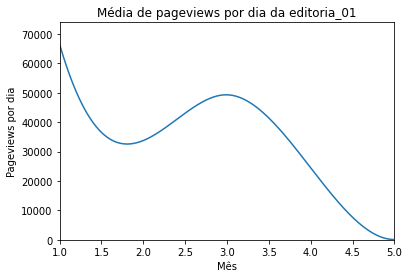

In [27]:
# visualização da média de pageviews por dia para cada mês da editoria_01
x_y_Spline = make_interp_spline(df_ed1['mes'], df_ed1['value_pag'])
x_ = np.linspace(1, 5, 200)
y_ = x_y_Spline(x_)
plt.plot(x_, y_)
plt.axis([1, 5, 0, 74000])
plt.ylabel('Pageviews por dia')
plt.xlabel('Mês')
plt.title('Média de pageviews por dia da editoria_01')
plt.show()

# 5. Simulação do problema resolvido

Para realizar a simulação do problema resolvido, vamos alterar os valores dos pageviews da editoria_01 após março para acompanhar a variação dos pageviews das outras editorias.

In [28]:
# filtro excluindo editoria_01 do df_ed
df_sem_ed1 = df_ed[(df_ed['editoria'] != 'editoria_01')]

# agrupamento das linhas por mês, somando value
df_sem_ed1 = df_sem_ed1.groupby(['mes']).agg({'value_pag': 'sum'}).reset_index()

# cálculo da média diária
for i in range(5):
    df_sem_ed1.loc[[i], ['value_pag']] = df_sem_ed1.loc[[i], ['value_pag']] / n_dias[i]

# média diária de pageviews por mês das editorias (sem a editoria_01)
df_sem_ed1.style.format('{:,.0f}').hide_index()

mes,value_pag
1,"69,566"
2,"76,411"
3,"97,325"
4,"90,512"
5,"60,879"


In [29]:
# criação da coluna de crescimento percentual
df_sem_ed1['crescimento_pct'] = 1.0

# cálculo do crescimento percentual mensal
for i in range(4):
    df_sem_ed1.loc[i+1, 'crescimento_pct'] = df_sem_ed1['value_pag'][i+1] / df_sem_ed1['value_pag'][i]

# crescimento percentual mensal do número médio de pageviews por dia (sem a editoria_01)
format_dict = {'value_pag': '{:,.0f}', 'crescimento_pct': '{:.2%}'}
df_sem_ed1.style.format(format_dict).hide_index()

mes,value_pag,crescimento_pct
1,"69,566",100.00%
2,"76,411",109.84%
3,"97,325",127.37%
4,"90,512",93.00%
5,"60,879",67.26%


In [30]:
# alteração dos valores de pageviews da editoria_01 em abril e maio
df_ed1_alterado = df_ed1.copy()
for i in range(2):
    df_ed1_alterado.loc[i+3, 'value_pag'] = df_ed1_alterado.loc[i+2, 'value_pag'] * df_sem_ed1.loc[i+3, 'crescimento_pct']

# transformação de value_pag em integer
df_ed1_alterado['value_pag'] = df_ed1_alterado['value_pag'].astype(int)

# média diária de pageviews por mês da editoria_01 (alterado)
df_ed1_alterado.style.format('{:,}').hide_index()

mes,value_pag
1,"66,549"
2,"33,781"
3,"49,350"
4,"45,895"
5,"30,870"


In [31]:
# criação de um df com mês e pageviews para inserção dos valores alterados
df_alterado = df_tratado.groupby(['mes']).agg({'value_pag': 'sum'}).reset_index()

# cálculo da média diária
for i in range(5):
    df_alterado.loc[[i], ['value_pag']] = df_alterado.loc[[i], ['value_pag']] / n_dias[i]

# novo total = antigo total - antigo valor de editoria_01 + novo valor de editoria_01
for i in range(2):
    df_alterado.loc[i+3, 'value_pag'] = \
        df_alterado.loc[i+3, 'value_pag'] - \
        df_ed1.loc[i+3, 'value_pag'] + \
        df_ed1_alterado.loc[i+3, 'value_pag']

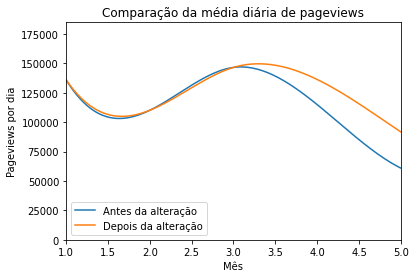

In [32]:
# comparação gráfica de antes e depois da alteração

# df com total de pageviews por mês (sem alteração)
df_sem_alteracao = df_tratado.groupby(['mes']).agg({'value_pag': 'sum'}).reset_index()

# cálculo da média diária
for i in range(5):
    df_sem_alteracao.loc[[i], ['value_pag']] = df_sem_alteracao.loc[[i], ['value_pag']] / n_dias[i]

# criação do gráfico da média diária de pageviews por mês (sem alteração)
xy_spline = make_interp_spline(df_sem_alteracao['mes'], df_sem_alteracao['value_pag'])
x = np.linspace(1, 5, 200)
y = xy_spline(x)
plt.plot(x, y, label='Antes da alteração')

# criação do gráfico da média diária de pageviews por mês (alterado)
x_y_spline = make_interp_spline(df_alterado['mes'], df_alterado['value_pag'])
y_ = x_y_spline(x)
plt.plot(x, y_, label='Depois da alteração')

# visualização da média diária de pageviews por mês, antes e depois da alteração
plt.axis([1, 5, 0, 185000])
plt.ylabel('Pageviews por dia')
plt.xlabel('Mês')
plt.title('Comparação da média diária de pageviews')
plt.legend(loc = "lower left")
plt.show()

In [33]:
# criação de um df para analisar a diferença de pageviews entre antes e depois da alteração dos valores da editoria_01
df_dif = df_sem_alteracao.copy()

# alteração do nome da coluna
df_dif = df_dif.rename(columns = {"value_pag": "value_pag_antes"})

# adição de uma coluna com os valores alterados
df_dif['value_pag_depois'] = df_alterado['value_pag']

# adição da coluna com a diferença
df_dif['diferenca'] = df_dif['value_pag_depois'] - df_dif['value_pag_antes']

# adição da coluna com o percentual da diferença
df_dif['diferenca_pct'] = df_dif['diferenca'] / df_dif['value_pag_antes']

# visualização da diferença de pageviews
format_dict = {
    'value_pag_antes': '{:,.0f}',
    'value_pag_depois': '{:,.0f}',
    'diferenca': '{:,.0f}',
    'diferenca_pct': '{:.2%}'}
df_dif.style.format(format_dict).hide_index()

mes,value_pag_antes,value_pag_depois,diferenca,diferenca_pct
1,"136,116","136,116",0,0.00%
2,"110,192","110,192",0,0.00%
3,"146,676","146,676",0,0.00%
4,"115,024","136,407","21,383",18.59%
5,"60,973","91,749","30,777",50.48%


In [34]:
# cálculo do total da diferença
print(n_dias[3] * 21383 + n_dias[4] * 30777)

733821


No cenário onde o número de pageviews da editoria_01 segue a mesma variação das outras editorias em abril e em maio, o valor total de pageviews aumentou em 18% em abril e 50% em março, totalizando 733,821 pageviews a mais.

# 6. Previsão de pageviews

Para a previsão do total de pageviews até o dia 7 de maio, usaremos o software de previsão criado pelo Facebook, Prophet.

O Prophet realiza previsões ajustando tendências não lineares à sazonalidade anual, semanal e diária, que podem ser ajustadas. O input é sempre um dataframe com duas colunas: ds e y. A coluna ds é a data e a coluna y representa a medida que desejamos prever.

Avaliaremos a previsão utilizando validação cruzada, utilizando como métrica a raiz quadrada do erro médio (rmse, em inglês).

Obs: Nessa etapa, a alteração dos pageviews da editoria_01 realizada na etapa anterior (Simulação do problema resolvido) não foi considerada.

In [35]:
# criação de um df com pageviews por dia para realizar a previsão
df_tratado_prev = df_tratado.groupby(['date']).agg({'value_pag': "sum"}).reset_index()

# alteração dos nomes das colunas
df_tratado_prev = df_tratado_prev.rename(columns = {"date": "ds", "value_pag": "y"})

# visualização das últimas linhas
format_dict = {'ds': '{:%Y-%m-%d}', 'y': '{:,}'}
df_tratado_prev.tail().style.format(format_dict)

,ds,y
118,2021-04-29,"74,261"
119,2021-04-30,"82,038"
120,2021-05-01,"49,860"
121,2021-05-02,"65,371"
122,2021-05-03,"67,687"


In [36]:
# remoção de valores extremos
df_tratado_prev['y'] = df_tratado_prev['y'].where(df_tratado_prev['y'] > 50000, None)
df_tratado_prev['y'] = df_tratado_prev['y'].where(df_tratado_prev['y'] < 200000, None)

In [37]:
# valores dos parâmetros que serão testados na validação cruzada
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# criação das combinações dos parâmetros e de uma variável para armazenar os rmses
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

In [38]:
# validação cruzada
for params in all_params:
    modelo = Prophet(**params)
    modelo.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
    modelo.add_country_holidays(country_name = 'BR')
    modelo.fit(df_tratado_prev)
    df_vc = cross_validation(modelo, initial = '60 days', horizon = '4 days')
    df_perf = performance_metrics(df_vc)
    rmses.append(df_perf['rmse'].values[0])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [39]:
# visulização dos rmses
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  34595.133349
1                     0.001                     0.10  43979.281981
2                     0.001                     1.00  45430.792072
3                     0.001                    10.00  45242.010896
4                     0.010                     0.01  34036.873874
5                     0.010                     0.10  42715.175433
6                     0.010                     1.00  44441.195618
7                     0.010                    10.00  44276.594360
8                     0.100                     0.01  34611.482100
9                     0.100                     0.10  42965.668194
10                    0.100                     1.00  44903.421310
11                    0.100                    10.00  44295.741551
12                    0.500                     0.01  30224.010681
13                    0.500                     0.10  40046.38

In [40]:
# seleção da melhor combinação de parâmetros com base no rmse
best_params = all_params[np.argmin(rmses)]
best_params

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}

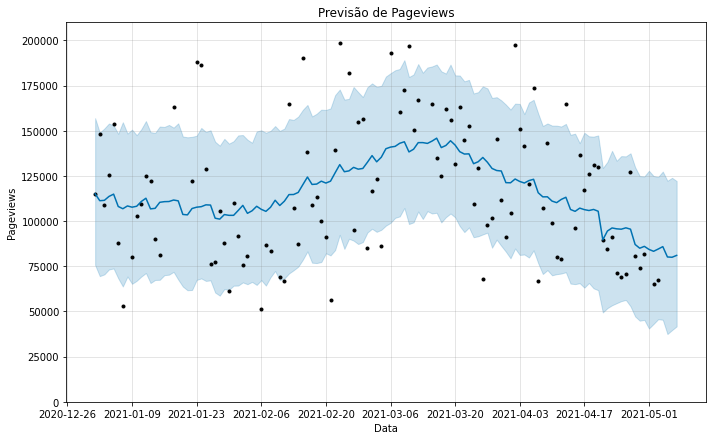

In [41]:
# criação do modelo para previsão
modelo = Prophet(**best_params)

# adição de uma sazonalidade mensal
modelo.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)

# adição de feriados
modelo.add_country_holidays(country_name = 'BR')

# ajuste do modelo
modelo.fit(df_tratado_prev)

# criação de um df com as datas a serem previstas
futuro = modelo.make_future_dataframe(periods = 4)

# previsão para cada data em futuro
previsao = modelo.predict(futuro)

# visualização da previsão
modelo.plot(previsao)
plt.title("Previsão de Pageviews")
plt.xlabel("Data")
plt.ylabel("Pageviews")
plt.ylim(0, 210000)
plt.show()

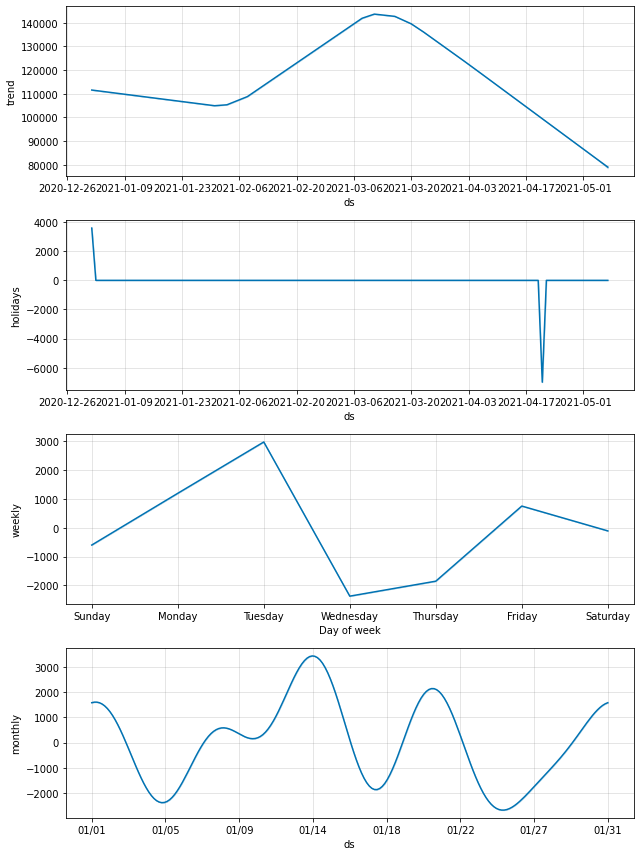

In [42]:
# visualização dos componentes da previsão
modelo.plot_components(previsao);

In [43]:
# transformação em integer
previsao[['yhat', 'yhat_lower', 'yhat_upper']] = \
    previsao[['yhat', 'yhat_lower', 'yhat_upper']].astype(int)

# visualização da previsão (yhat) e dos intervalos de incerteza
format_dict = {'ds': '{:%Y-%m-%d}', 'yhat': '{:,}', 'yhat_lower': '{:,}', 'yhat_upper': '{:,}'}
previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail().style.format(format_dict)

,ds,yhat,yhat_lower,yhat_upper
122,2021-05-03,"84,550","45,731","124,472"
123,2021-05-04,"85,889","45,397","127,441"
124,2021-05-05,"80,173","37,504","122,334"
125,2021-05-06,"80,000","39,693","123,972"
126,2021-05-07,"81,039","41,733","122,212"


A previsão do total de pageviews é:

- 80,173 de pageviews no dia 5 de maio
- 80,000 de pageviews no dia 6 de maio
- 81,039 de pageviews no dia 7 de maio

# 7. Conclusão

Nesse notebook, foi analisado o dataset de uma empresa de mídia hipotética. Para explicar a causa da queda na principal métrica de audiência, o número de pageviews, foi investigada a sua relação com as variáveis do dataset. Após a descoberta da principal causa do problema, foi realizada uma simulação da série de pageviews caso esse problema fosse resolvido. Além disso, foi feita a previsão do número de pageviews total dos dias 5, 6 e 7 de maio.

Os resultados encontrados foram:
- A redução do número de pageviews na editoria_01 a partir de abril foi a principal causa da queda na audiência da empresa. No primeiro trimestre, a editoria_01 foi a editoria com mais pageviews, mas o valor caiu de 49,351 por dia em março, para 93 por dia em maio. Na simulação do problema resolvido, a empresa teve 733,821 pageviews a mais nesse período.
- A previsão de pageviews para os dias 5, 6 e 7 de maio é, respectivamente: 80,173, 80,000 e 81,039.